In [ ]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
from utils import Params
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image
from GLOnet_thinfilm import GLOnet
import scipy.io as io
from TMM import *
from material_database import MatDatabase
from scipy.optimize import fsolve

### Optimization for incandescent light bulb filters


In [ ]:
Vis = [0.5, 0.7]
params = Params()
params.N_layers = 30
params.pol = 'TM'
params.k =  2 * math.pi / torch.cat([torch.linspace(0.3, Vis[0], 10), torch.linspace(Vis[0], Vis[1], 50), torch.linspace(Vis[1], 1.5, 90), torch.linspace(1.5, 2.5, 80)])
params.theta =   torch.tensor([0.]) 
params.n_top = torch.tensor([1.])
params.n_bot = torch.tensor([1.])

params.user_define = False
## choose from material database
params.materials = ['Al2O3', 'MgF2', 'TiO2', 'SiC', 'SiN', 'SiO2', 'HfO2']
params.matdatabase = MatDatabase(params.materials)
params.n_database = params.matdatabase.interp_wv(2 * math.pi/params.k, params.materials, True) # number of materials x number of frequencies
params.M_materials = params.n_database.size(0)
params.target_reflection = torch.ones((1, params.k.size(0), 1, 1)) # 1 x number of frequencies x number of angles x (number of pol or 1)
params.target_reflection[:,10:60, :, :] = 0
params.thickness_sup = 0.3 # [um]
params.alpha_sup = 4

params.net = 'DNN'
params.kernel = 7
params.padding = 5
params.res_layers = 8 
params.res_dim = 64 
params.noise_dim = 16 

params.lr = 0.05
params.beta1 = 0.9
params.beta2 = 0.99
params.weight_decay = 0.00
params.step_size = 40000
params.gamma = 0.5
params.numIter = 500
params.batch_size = 500
params.sigma = 0.2

100%|██████████| 500/500 [01:09<00:00,  7.22it/s]


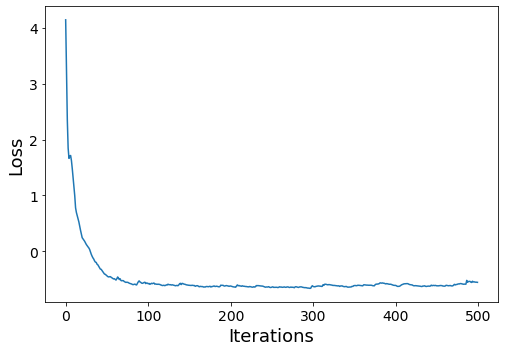

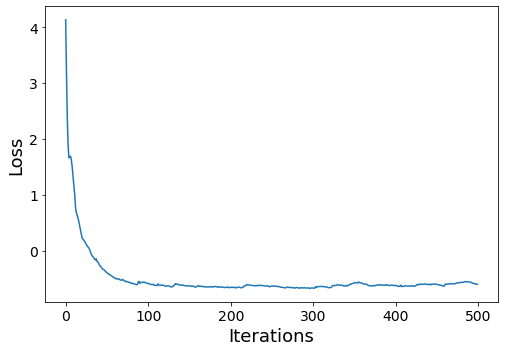

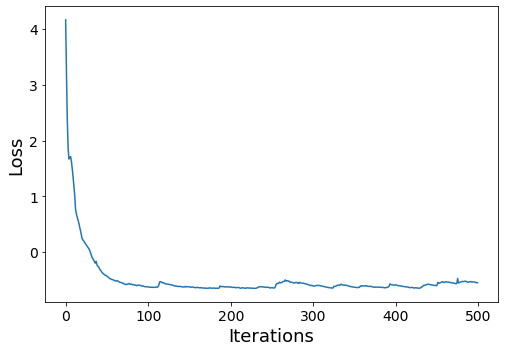

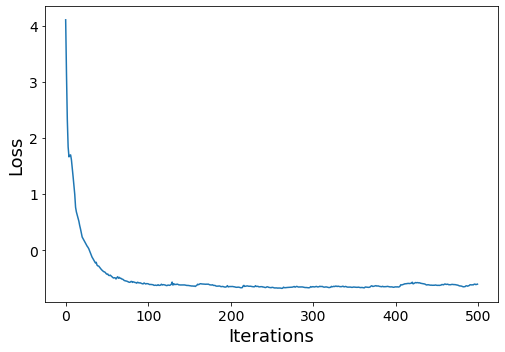

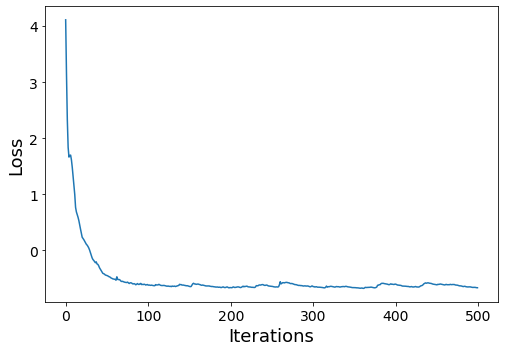

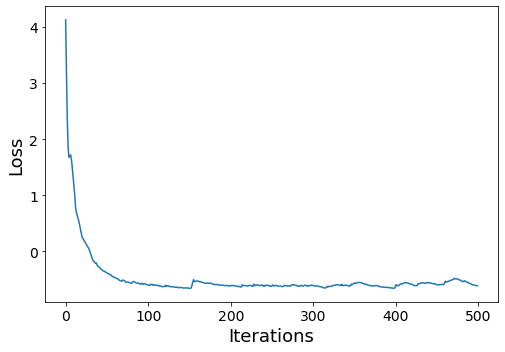

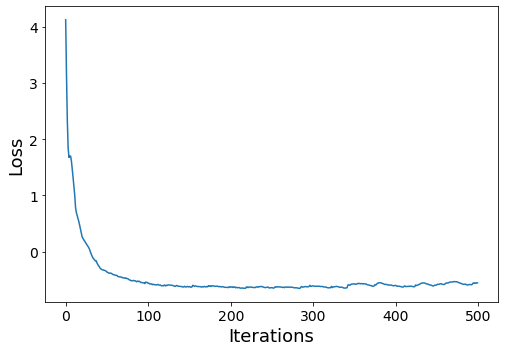

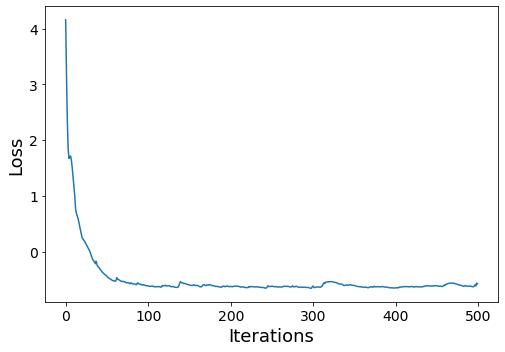

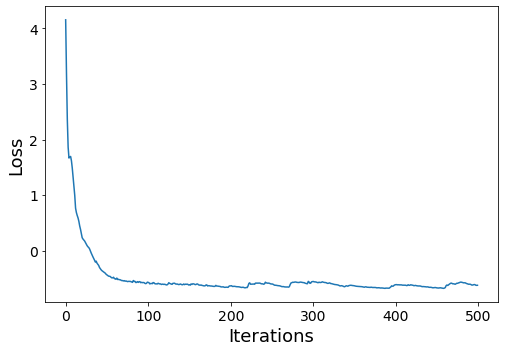

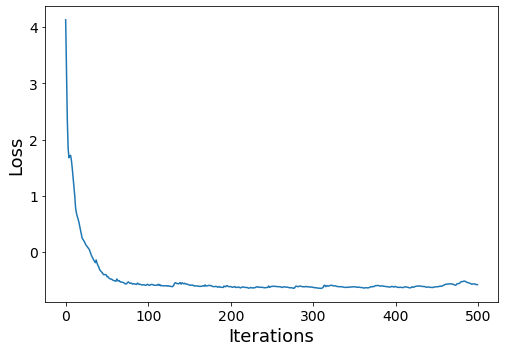

In [ ]:
results = []
for i in range(1):
    glonet = GLOnet(params)
    glonet.train()
    glonet.viz_training()
    glonet.generator.eval()
    (thicknesses, refractive_indices, result_mat, reflection) = glonet.evaluate(100, kvector = params.k, 
                                                                                inc_angles = params.theta, pol = 'TM', 
                                                                                grayscale=False)
   
    FoM = torch.pow(reflection - params.target_reflection.cuda(), 2).mean(dim=[1, 2, 3])
    _, indices = torch.sort(FoM)
    opt_idx = indices[0]
    results.append(FoM[opt_idx])

tensor(0.0971, device='cuda:0')


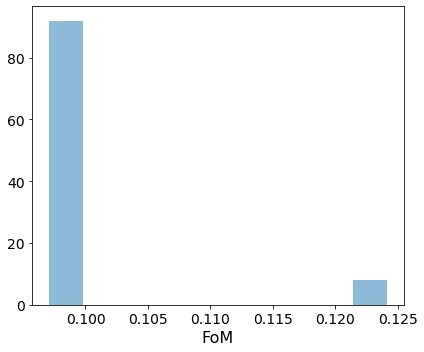

In [ ]:
with torch.no_grad():
    params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 400)
    params.theta_test = torch.linspace(0, math.pi/2.25, 200)
    glonet.generator.eval()
    (thicknesses, refractive_indices, result_mat, reflection) = glonet.evaluate(100, kvector = params.k_test, 
                                                                                inc_angles = params.theta_test, pol = 'Both', 
                                                                                grayscale=False)
    
    params.target_reflection = torch.ones((1, params.k_test.size(0), 1, 1)) # 1 x number of frequencies x number of angles x (number of pol or 1)
    dx = (2.5-0.3)/400
    idx_start = round((Vis[0]-0.3)/dx)
    idx_end = round((Vis[1]-0.3)/dx)
    params.target_reflection[:, idx_start:idx_end, :, :] = 0


    FoM = torch.pow(reflection - params.target_reflection.cuda(), 2).mean(dim=[1, 2, 3])
    _, indices = torch.sort(FoM)
    opt_idx = indices[0]


    plt.figure(figsize=(6,5))
    plt.hist(FoM.cpu().detach().numpy(), alpha = 0.5)
    plt.xlabel('FoM', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print(FoM[opt_idx])

    ref_idx_opt = refractive_indices[opt_idx].detach().cpu()
    thickness_opt = thicknesses[opt_idx].detach().cpu()
    mat_opt = [params.materials[result_mat[opt_idx, i]] for i in range(result_mat.size(1))]

In [ ]:
print(thickness_opt)
print(ref_idx_opt)
print(mat_opt)

tensor([0.1122, 0.2069, 0.2078, 0.1577, 0.1080, 0.1638, 0.1476, 0.2349, 0.1130,
        0.1627, 0.2282, 0.1500, 0.1164, 0.2072, 0.1137, 0.2063, 0.1145, 0.1069,
        0.1947, 0.0920, 0.1484, 0.1760, 0.1089, 0.1718, 0.1567, 0.2084, 0.1076,
        0.1998, 0.1964, 0.1101])
tensor([[3.5135, 3.5406, 3.5379,  ..., 2.3821, 2.3821, 2.3821],
        [1.3930, 1.3922, 1.3915,  ..., 1.3643, 1.3643, 1.3643],
        [1.3930, 1.3922, 1.3915,  ..., 1.3643, 1.3643, 1.3643],
        ...,
        [1.3930, 1.3922, 1.3915,  ..., 1.3643, 1.3643, 1.3643],
        [1.3930, 1.3922, 1.3915,  ..., 1.3643, 1.3643, 1.3643],
        [2.5880, 2.5880, 2.5880,  ..., 2.5624, 2.5622, 2.5621]])
['TiO2', 'MgF2', 'MgF2', 'Al2O3', 'SiC', 'MgF2', 'SiN', 'MgF2', 'SiC', 'SiO2', 'MgF2', 'Al2O3', 'SiC', 'MgF2', 'SiN', 'MgF2', 'SiC', 'SiC', 'MgF2', 'SiC', 'HfO2', 'SiO2', 'SiC', 'Al2O3', 'Al2O3', 'SiO2', 'SiC', 'MgF2', 'MgF2', 'SiC']


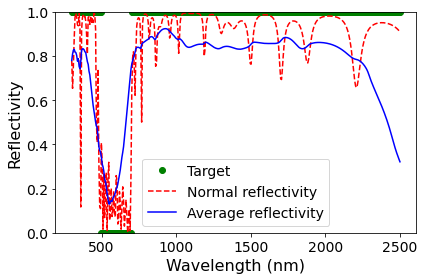

In [ ]:
params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 400)
params.theta_test = torch.linspace(0, math.pi/2.25, 200)
reflection = glonet._TMM_solver(thicknesses[opt_idx].unsqueeze(0),
                   result_mat[opt_idx].unsqueeze(0),
                   kvector = params.k_test,
                   inc_angles = params.theta_test, 
                   pol = 'Both')
reflection_opt = reflection[0].detach().cpu()

params.target_reflection = torch.ones((1, params.k_test.size(0), 1, 1)) # 1 x number of frequencies x number of angles x (number of pol or 1)
dx = (2.5-0.3)/400
idx_start = round((Vis[0]-0.3)/dx)
idx_end = round((Vis[1]-0.3)/dx)
params.target_reflection[:, idx_start:idx_end, :, :] = 0

dtheta = params.theta_test[1] - params.theta_test[0]
aver_reflection = torch.sum(reflection_opt.mean(dim=2) * torch.sin(2 * params.theta_test).view(1,-1), dim=1) * dtheta

# plot
plt.plot(2*math.pi/params.k_test*1000, params.target_reflection[0, :, 0, 0].view(-1).numpy(), 'go')
plt.plot(2*math.pi/params.k_test*1000, reflection_opt[:, 0, 0].view(-1).numpy(), '--r', )
plt.plot(2*math.pi/params.k_test*1000, aver_reflection.view(-1).numpy(), '-b')
plt.ylabel('Reflectivity', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Target', 'Normal reflectivity', 'Average reflectivity'], fontsize = 14)
plt.savefig('Fig4b.png', dpi=300)

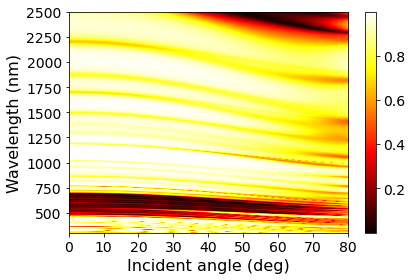

In [ ]:
plt.imshow(reflection_opt.mean(dim=-1).detach().cpu().numpy(), origin='lower', aspect='auto', cmap='hot', extent=[0, 80, 300, 2500])
plt.colorbar().ax.tick_params(labelsize=14)
plt.xlabel('Incident angle (deg)', fontsize=16)
plt.ylabel('Wavelength (nm)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Fig4c.png', dpi=300)
